---
# Projeto - Identificação de desmatamento na Amazônia em imagens de satélite
---
**Machine Learning em Projetos (Pedro, Rayder e Cassiano)**

## Introdução

### **Descrição do projeto de machine learning**
**1- Descrição do problema ou tarefa:**  
A identificação manual de desmatamento é uma tarefa custosa e trabalhosa

**2- Descrição da solução de IA:**  
Treinar algoritmos de machine learning para identificar desmatamento a partir de imagens de satélite.

**3- Fonte de dados:**  
PRODES (INPE) e Imagens de satélite no Google Earth Engine.

**4- Variáveis independentes (preditoras ou "features"):**  
Atributos extraídos das imagens de satélite [tabela de atributos numéricos (NDVI), (NDWI) e (SWIR)]

(NDVI) = Normalized Difference Vegetation Index

(NDWI) = Normalized Difference Water Index

(SWIR) = Infravermelho de ondas curtas.

**5- Variável dependente (resposta ou "target"):** 
1: Desmatamento,
0: Floresta

Autor do caderno: Pedro, Rayder e Cassiano    
Data:24/11/2021  

Fonte: https://github.com/fernandosola/eniac2021-article/blob/main/c01_experimentos_estruturados.ipynb

## Carregar bibliotecas de código

In [ ]:
import datetime
import re
import json
import yaml
import sys
import os
import logging
import logging.config
import time
import multiprocessing
from collections import OrderedDict
import requests
import sqlalchemy
import string
import unicodedata
import yaml
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import tqdm

import numpy as np
from scipy.sparse import issparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    balanced_accuracy_score,
    average_precision_score,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Binarizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import joblib
from joblib import delayed, Parallel

#################################
# VARIÁVEIS GLOBAIS
#################################
N_JOBS = -1
BASE_DIR = './'
DEFAULT_RANDOM_STATE = 42

#################################
# CONFIGURAÇÕES
#################################
pd.options.display.max_rows = 500

In [ ]:
# Importar bibliotecas (pandas etc)
import numpy as np
import pandas as pd

# Importar algoritmo

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, make_scorer,  accuracy_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score

from tensorflow.keras.layers import Input, Dense, Dropout, Activation  #importando as camadas a serem utilizadas
from tensorflow.keras.models import Model  #importando o modelo a ser empregado
from keras.models import Sequential, Model  #utilizada para criar o modelo sequencial da MLP
from keras.layers import Dense, Dropout, Input #utilizada para criar as camadas da rede
import seaborn as sns #plotar gráficos

from keras import backend as K

import missingno as msno


In [ ]:
%%capture
!pip install pdpbox
!pip install lime
!pip install shap
!pip install eli5
!pip install mlxtend
!pip install interpret

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns  

import sklearn #for building models
import xgboost as xgb #for building models
import sklearn.ensemble #for building models
from sklearn.model_selection import train_test_split #for creating a hold-out sample
from sklearn import datasets # Boston Housing Data

# Explainable ML&AI 

import lime 
import lime.lime_tabular 
import shap 
import yellowbrick as yb
from pdpbox import pdp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd /content/drive/MyDrive/Colab Notebooks/bootcamp_ml_enap/dados

/content/drive/MyDrive/Colab Notebooks/bootcamp_ml_enap/dados


In [ ]:
# Importar dados
df = pd.read_csv("tabela_com_amostras.csv")
print("SHAPE: ",df.shape)
df.head()

SHAPE:  (106346, 85)


,masked,mean,classe_amostra,fid,MEDIA_NDVI_2015,MEDIA_NDVI_2016,MEDIA_NDVI_2017,MEDIA_NDVI_2018,MEDIA_NDVI_2019,MEDIA_NDVI_2020,MEDIA_NDVI_2021,MEDIANA_NDVI_2015,MEDIANA_NDVI_2016,MEDIANA_NDVI_2017,MEDIANA_NDVI_2018,MEDIANA_NDVI_2019,MEDIANA_NDVI_2020,MEDIANA_NDVI_2021,SD_NDVI_2015,SD_NDVI_2016,SD_NDVI_2017,SD_NDVI_2018,SD_NDVI_2019,SD_NDVI_2020,SD_NDVI_2021,MEDIA_ndwi_2015,MEDIA_ndwi_2016,MEDIA_ndwi_2017,MEDIA_ndwi_2018,MEDIA_ndwi_2019,MEDIA_ndwi_2020,MEDIA_ndwi_2021,MEDIANA_ndwi_2015,MEDIANA_ndwi_2016,MEDIANA_ndwi_2017,MEDIANA_ndwi_2018,MEDIANA_ndwi_2019,MEDIANA_ndwi_2020,MEDIANA_ndwi_2021,SD_ndwi_2015,...,SD_ndwi_2021,MEDIA_swir_2015,MEDIA_swir_2016,MEDIA_swir_2017,MEDIA_swir_2018,MEDIA_swir_2019,MEDIA_swir_2020,MEDIA_swir_2021,MEDIANA_swir_2015,MEDIANA_swir_2016,MEDIANA_swir_2017,MEDIANA_swir_2018,MEDIANA_swir_2019,MEDIANA_swir_2020,MEDIANA_swir_2021,SD_swir_2015,SD_swir_2016,SD_swir_2017,SD_swir_2018,SD_swir_2019,SD_swir_2020,SD_swir_2021,MEDIA_sentinel_2016,MEDIA_sentinel_2017,MEDIA_sentinel_2018,MEDIA_sentinel_2019,MEDIA_sentinel_2020,MEDIA_sentinel_2021,MEDIANA_sentinel_2016,MEDIANA_sentinel_2017,MEDIANA_sentinel_2018,MEDIANA_sentinel_2019,MEDIANA_sentinel_2020,MEDIANA_sentinel_2021,SD_sentinel_2016,SD_sentinel_2017,SD_sentinel_2018,SD_sentinel_2019,SD_sentinel_2020,SD_sentinel_2021
0,-1078580800,-1078580800,0.0,1,0.860178,0.862347,0.880624,0.876968,0.874338,0.866653,0.874047,0.858046,0.861705,0.880325,0.878201,0.872291,0.866706,0.873053,0.006647,0.006360,0.011249,0.010114,0.006904,0.006366,0.010788,0.411619,0.422723,0.450105,0.444348,0.440827,0.439741,0.442109,0.410668,0.418522,0.453245,0.447814,0.434582,0.439734,0.445001,0.010994,...,0.020057,0.045178,0.042401,0.040698,0.040803,0.039660,0.042483,0.041667,0.045781,0.042646,0.041203,0.040804,0.040020,0.042124,0.042578,0.002567,0.003107,0.002925,0.003616,0.002909,0.002553,0.003242,-13.824680,-13.751174,-14.481498,-14.332572,-14.025660,-14.159876,-13.930913,-13.416140,-14.576889,-14.331479,-14.260532,-14.111591,1.262125,1.072656,0.847374,0.855016,0.971473,1.250368
1,-1127396665,-1127396665,NaN,2,0.826198,0.861789,0.858303,0.876121,0.843605,0.857290,0.857423,0.831246,0.865362,0.854957,0.871255,0.838356,0.863312,0.863969,0.013040,0.009522,0.005938,0.011277,0.010649,0.013060,0.012535,0.391470,0.404147,0.387315,0.421452,0.408952,0.436466,0.418396,0.382412,0.402343,0.372811,0.408203,0.421082,0.433053,0.406094,0.018645,...,0.041569,0.041624,0.038145,0.036294,0.034337,0.038773,0.035162,0.037316,0.040515,0.036830,0.036060,0.034039,0.036390,0.037834,0.039621,0.003808,0.005408,0.005250,0.005595,0.005490,0.004892,0.005395,-16.607193,-17.103259,-17.925755,-17.880660,-18.054371,-17.233654,-16.343923,-16.892206,-17.808227,-17.220579,-17.949005,-17.016452,0.750684,0.929176,0.729162,1.902690,1.337784,0.713757
2,231191332,231191332,0.0,3,0.835334,0.842979,0.841535,0.840028,0.818171,0.834221,0.846946,0.830686,0.840736,0.852647,0.845784,0.845801,0.840803,0.858806,0.014755,0.012962,0.019986,0.014076,0.059527,0.018637,0.026971,0.414819,0.414943,0.406116,0.411079,0.407709,0.403399,0.404860,0.409810,0.419160,0.412292,0.406481,0.416200,0.409798,0.426004,0.009141,...,0.037577,0.037229,0.033988,0.033282,0.033755,0.031422,0.035098,0.032581,0.035785,0.034809,0.034011,0.032623,0.033915,0.035758,0.034231,0.002828,0.001943,0.002006,0.002490,0.004901,0.002180,0.003521,-15.849317,-15.879657,-15.904003,-15.790441,-15.811666,-16.635458,-15.969233,-15.560113,-15.598380,-15.491156,-15.833027,-16.086756,0.629769,0.801905,0.760380,2.286041,1.119886,1.935816
3,-1127396665,-1127396665,NaN,4,0.840929,0.840058,0.832866,0.846502,0.839763,0.830259,0.850966,0.840929,0.840058,0.832866,0.846502,0.839763,0.830259,0.850966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398562,0.384476,0.384224,0.406581,0.438750,0.454734,0.452517,0.398562,0.384476,0.384224,0.406581,0.438750,0.454734,0.452517,NaN,...,NaN,0.039717,0.035634,0.034644,0.033571,0.038178,0.032196,0.032609,0.039717,0.035634,0.034644,0.033571,0.038178,0.032196,0.032609,NaN,NaN,Na

Este comando deve ser analisado pois esta causando erro

## 1- Análise exploratória do dados

In [ ]:
# Ler dados previsão
df = df.drop(columns=["MEDIA_sentinel_2016",	"MEDIA_sentinel_2017",	"MEDIA_sentinel_2018",	"MEDIA_sentinel_2019",	"MEDIA_sentinel_2020",
                 "MEDIA_sentinel_2021",	"MEDIANA_sentinel_2016", "MEDIANA_sentinel_2017",	"MEDIANA_sentinel_2018", 
                 "MEDIANA_sentinel_2019",	"MEDIANA_sentinel_2020",	"MEDIANA_sentinel_2021"])
df=df.drop(columns=["SD_NDVI_2015","SD_NDVI_2016","SD_NDVI_2017","SD_NDVI_2018","SD_NDVI_2019","SD_NDVI_2020","SD_NDVI_2021"])
df=df.drop(columns=["SD_ndwi_2015","SD_ndwi_2016","SD_ndwi_2017","SD_ndwi_2018","SD_ndwi_2019","SD_ndwi_2020","SD_ndwi_2021"])
df=df.drop(columns=["SD_swir_2015","SD_swir_2016","SD_swir_2017","SD_swir_2018","SD_swir_2019","SD_swir_2020","SD_swir_2021"])
df=df.drop(columns=["SD_sentinel_2016","SD_sentinel_2017","SD_sentinel_2018","SD_sentinel_2019","SD_sentinel_2020","SD_sentinel_2021"])

In [ ]:
dados_previsao=df.iloc[:,2:]
dados_previsao=dados_previsao[pd.isna(dados_previsao['classe_amostra'])==True]
dados_previsao=dados_previsao.fillna(dados_previsao.mean())
dados_previsao.shape

(74346, 44)

In [ ]:
dados_previsao.describe()

,classe_amostra,fid,MEDIA_NDVI_2015,MEDIA_NDVI_2016,MEDIA_NDVI_2017,MEDIA_NDVI_2018,MEDIA_NDVI_2019,MEDIA_NDVI_2020,MEDIA_NDVI_2021,MEDIANA_NDVI_2015,MEDIANA_NDVI_2016,MEDIANA_NDVI_2017,MEDIANA_NDVI_2018,MEDIANA_NDVI_2019,MEDIANA_NDVI_2020,MEDIANA_NDVI_2021,MEDIA_ndwi_2015,MEDIA_ndwi_2016,MEDIA_ndwi_2017,MEDIA_ndwi_2018,MEDIA_ndwi_2019,MEDIA_ndwi_2020,MEDIA_ndwi_2021,MEDIANA_ndwi_2015,MEDIANA_ndwi_2016,MEDIANA_ndwi_2017,MEDIANA_ndwi_2018,MEDIANA_ndwi_2019,MEDIANA_ndwi_2020,MEDIANA_ndwi_2021,MEDIA_swir_2015,MEDIA_swir_2016,MEDIA_swir_2017,MEDIA_swir_2018,MEDIA_swir_2019,MEDIA_swir_2020,MEDIA_swir_2021,MEDIANA_swir_2015,MEDIANA_swir_2016,MEDIANA_swir_2017,MEDIANA_swir_2018,MEDIANA_swir_2019,MEDIANA_swir_2020,MEDIANA_swir_2021
count,0.0,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000,74346.000000
mean,NaN,53135.629059,0.743209,0.776352,0.761971,0.764686,0.736634,0.754493,0.721644,0.743652,0.777383,0.762839,0.765479,0.737026,0.755297,0.722213,0.270384,0.291541,0.282952,0.278522,0.254057,0.274158,0.231866,0.270419,0.291966,0.283137,0.278589,0.253657,0.274233,0.231535,0.083208,0.075097,0.080215,0.079815,0.088077,0.081050,0.093806,0.083026,0.074867,0.080007,0.079642,0.087987,0.080879,0.093702
std,NaN,30712.080078,0.157367,0.152016,0.168442,0.167682,0.185956,0.151779,0.186203,0.159200,0.153183,0.170039,0.169263,0.188337,0.153271,0.188528,0.184620,0.161378,0.182814,0.180393,0.205155,0.167570,0.199598,0.187444,0.163395,0.185259,0.182950,0.208545,0.169964,0.202935,0.052658,0.046773,0.051553,0.050806,0.058817,0.046122,0.059154,0.053246,0.047149,0.052011,0.051297,0.059540,0.046605,0.059928
min,NaN,2.000000,-0.058823,-0.753315,-0.698779,-0.655755,-0.732905,-0.398661,-0.602182,-0.084975,-0.753315,-0.698779,-0.655755,-0.732905,-0.410893,-0.602182,-0.284667,-0.388610,-0.286364,-0.279941,-0.276545,-0.316976,-0.327896,-0.325422,-0.388610,-0.284559,-0.279941,-0.281252,-0.316976,-0.327896,0.009550,0.005953,0.005853,0.006411,0.006553,0.006971,0.006556,0.009550,0.002936,0.003307,0.003693,0.004517,0.004188,0.003913
25%,NaN,26547.500000,0.659369,0.703451,0.661773,0.669109,0.608288,0.665667,0.576310,0.658941,0.703841,0.661178,0.668763,0.606588,0.665278,0.572974,0.144871,0.194410,0.147761,0.149774,0.088019,0.151528,0.052747,0.142467,0.194361,0.146645,0.148059,0.085110,0.149776,0.048271,0.049163,0.045108,0.045345,0.045613,0.046785,0.047720,0.048407,0.049026,0.045011,0.045204,0.045493,0.046634,0.047500,0.048242
50%,NaN,53187.000000,0.832705,0.859150,0.861244,0.860958,0.849734,0.833576,0.829406,0.834167,0.860918,0.863336,0.863040,0.852549,0.836367,0.836162,0.373107,0.380099,0.388763,0.381759,0.375430,0.367327,0.339739,0.374854,0.381776,0.390832,0.383873,0.378037,0.370105,0.345393,0.053790,0.049604,0.050827,0.051006,0.053249,0.056538,0.060248,0.053454,0.049288,0.050394,0.050518,0.052615,0.055764,0.058033
75%,NaN,79799.750000,0.847846,0.874426,0.876273,0.877694,0.869625,0.864224,0.868687,0.848468,0.875360,0.877286,0.878699,0.870729,0.865339,0.869900,0.397608,0.401616,0.413790,0.407308,0.406809,0.401639,0.398487,0.398245,0.402517,0.414558,0.408295,0.407902,0.402738,0.399950,0.107115,0.096378,0.109135,0.107259,0.124046,0.108165,0.135720,0.106680,0.095988,0.108878,0.107117,0.124046,0.108110,0.136157
max,NaN,106345.000000,0.962676,0.919625,0.916679,0.921921,0.910134,0.914087,0.912668,0.962676,0.919625,0.916679,0.921921,0.910134,0.914087,0.912668,0.525517,0.517669,0.623037,0.523173,0.550693,0.611793,0.529844,0.525517,0.555637,0.645809,0.523173,0.555820,0.611793,0.626040,0.82

In [ ]:
# mostrar as primeiras linhas do dataset
dados_previsao.head()

,classe_amostra,fid,MEDIA_NDVI_2015,MEDIA_NDVI_2016,MEDIA_NDVI_2017,MEDIA_NDVI_2018,MEDIA_NDVI_2019,MEDIA_NDVI_2020,MEDIA_NDVI_2021,MEDIANA_NDVI_2015,MEDIANA_NDVI_2016,MEDIANA_NDVI_2017,MEDIANA_NDVI_2018,MEDIANA_NDVI_2019,MEDIANA_NDVI_2020,MEDIANA_NDVI_2021,MEDIA_ndwi_2015,MEDIA_ndwi_2016,MEDIA_ndwi_2017,MEDIA_ndwi_2018,MEDIA_ndwi_2019,MEDIA_ndwi_2020,MEDIA_ndwi_2021,MEDIANA_ndwi_2015,MEDIANA_ndwi_2016,MEDIANA_ndwi_2017,MEDIANA_ndwi_2018,MEDIANA_ndwi_2019,MEDIANA_ndwi_2020,MEDIANA_ndwi_2021,MEDIA_swir_2015,MEDIA_swir_2016,MEDIA_swir_2017,MEDIA_swir_2018,MEDIA_swir_2019,MEDIA_swir_2020,MEDIA_swir_2021,MEDIANA_swir_2015,MEDIANA_swir_2016,MEDIANA_swir_2017,MEDIANA_swir_2018,MEDIANA_swir_2019,MEDIANA_swir_2020,MEDIANA_swir_2021
1,NaN,2,0.826198,0.861789,0.858303,0.876121,0.843605,0.857290,0.857423,0.831246,0.865362,0.854957,0.871255,0.838356,0.863312,0.863969,0.391470,0.404147,0.387315,0.421452,0.408952,0.436466,0.418396,0.382412,0.402343,0.372811,0.408203,0.421082,0.433053,0.406094,0.041624,0.038145,0.036294,0.034337,0.038773,0.035162,0.037316,0.040515,0.036830,0.036060,0.034039,0.036390,0.037834,0.039621
3,NaN,4,0.840929,0.840058,0.832866,0.846502,0.839763,0.830259,0.850966,0.840929,0.840058,0.832866,0.846502,0.839763,0.830259,0.850966,0.398562,0.384476,0.384224,0.406581,0.438750,0.454734,0.452517,0.398562,0.384476,0.384224,0.406581,0.438750,0.454734,0.452517,0.039717,0.035634,0.034644,0.033571,0.038178,0.032196,0.032609,0.039717,0.035634,0.034644,0.033571,0.038178,0.032196,0.032609
7,NaN,8,0.839389,0.858656,0.863211,0.874242,0.859572,0.853679,0.869223,0.839389,0.858656,0.863211,0.874242,0.859572,0.853679,0.869223,0.378657,0.383391,0.375956,0.389287,0.372518,0.398339,0.396942,0.378657,0.383391,0.375956,0.389287,0.372518,0.398339,0.396942,0.049755,0.046799,0.048669,0.046991,0.047472,0.046290,0.045603,0.049755,0.046799,0.048669,0.046991,0.047472,0.046290,0.045603
8,NaN,9,0.844355,0.857786,0.866872,0.871467,0.864374,0.863333,0.873615,0.842285,0.858189,0.865106,0.871935,0.862364,0.863767,0.875707,0.377856,0.389295,0.402227,0.404883,0.400821,0.415620,0.415493,0.374165,0.387247,0.399540,0.406392,0.396153,0.417802,0.412281,0.049113,0.044180,0.043799,0.043430,0.044110,0.044776,0.043416,0.049095,0.044448,0.044131,0.043746,0.043980,0.045864,0.044159
9,NaN,10,0.866410,0.863013,0.878419,0.884443,0.882508,0.891164,0.895696,0.866410,0.863013,0.878419,0.884443,0.882508,0.891164,0.895696,0.396192,0.422735,0.438081,0.466510,0.446831,0.469991,0.476678,0.396192,0.422735,0.438081,0.466510,0.446831,0.469991,0.476678,0.044379,0.041141,0.040137,0.037036,0.039278,0.037916,0.040673,0.044379,0.041141,0.040137,0.037036,0.039278,0.037916,0.040673


In [ ]:
# Ler dados treinamento
df2=df.iloc[:,2:]
treinamento=df2[pd.isna(df2['classe_amostra'])==False]
y=treinamento['classe_amostra']
treinamento=treinamento.drop(columns=['classe_amostra'])
treinamento=treinamento.fillna(treinamento.mean())
treinamento.shape

(32000, 43)

In [ ]:
treinamento.describe()

,fid,MEDIA_NDVI_2015,MEDIA_NDVI_2016,MEDIA_NDVI_2017,MEDIA_NDVI_2018,MEDIA_NDVI_2019,MEDIA_NDVI_2020,MEDIA_NDVI_2021,MEDIANA_NDVI_2015,MEDIANA_NDVI_2016,MEDIANA_NDVI_2017,MEDIANA_NDVI_2018,MEDIANA_NDVI_2019,MEDIANA_NDVI_2020,MEDIANA_NDVI_2021,MEDIA_ndwi_2015,MEDIA_ndwi_2016,MEDIA_ndwi_2017,MEDIA_ndwi_2018,MEDIA_ndwi_2019,MEDIA_ndwi_2020,MEDIA_ndwi_2021,MEDIANA_ndwi_2015,MEDIANA_ndwi_2016,MEDIANA_ndwi_2017,MEDIANA_ndwi_2018,MEDIANA_ndwi_2019,MEDIANA_ndwi_2020,MEDIANA_ndwi_2021,MEDIA_swir_2015,MEDIA_swir_2016,MEDIA_swir_2017,MEDIA_swir_2018,MEDIA_swir_2019,MEDIA_swir_2020,MEDIA_swir_2021,MEDIANA_swir_2015,MEDIANA_swir_2016,MEDIANA_swir_2017,MEDIANA_swir_2018,MEDIANA_swir_2019,MEDIANA_swir_2020,MEDIANA_swir_2021
count,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,53261.486031,0.742898,0.775673,0.761310,0.764625,0.735790,0.753420,0.720180,0.743366,0.776665,0.762215,0.765506,0.736171,0.754257,0.720704,0.269471,0.290324,0.281779,0.277712,0.252576,0.272344,0.229619,0.269544,0.290726,0.282020,0.277926,0.252224,0.272496,0.229233,0.083492,0.075551,0.080596,0.080155,0.088659,0.081622,0.094431,0.083313,0.075328,0.080371,0.079965,0.088579,0.081451,0.094320
std,30670.851778,0.157102,0.152864,0.169181,0.167390,0.186921,0.152192,0.186886,0.158915,0.153987,0.170650,0.168815,0.189306,0.153612,0.189324,0.184602,0.162313,0.183209,0.180672,0.205888,0.168256,0.200160,0.187394,0.164417,0.185656,0.183195,0.209221,0.170676,0.203568,0.052752,0.047171,0.051881,0.051009,0.059436,0.046384,0.059338,0.053319,0.047574,0.052326,0.051519,0.060166,0.046891,0.060125
min,1.000000,-0.025115,-0.526527,-0.473162,-0.515614,-0.591021,-0.388916,-0.488059,-0.025115,-0.612917,-0.559396,-0.594904,-0.680543,-0.468174,-0.576912,-0.227145,-0.250002,-0.281202,-0.270445,-0.483682,-0.289362,-0.335072,-0.227145,-0.258366,-0.285603,-0.270445,-0.483682,-0.291550,-0.334558,0.014627,0.003329,0.003532,0.004050,0.004454,0.004528,0.004568,0.009619,0.002263,0.002503,0.002977,0.003287,0.003259,0.003225
25%,26682.750000,0.656268,0.701615,0.659527,0.668021,0.606290,0.663715,0.572403,0.656931,0.702097,0.658803,0.667257,0.603634,0.663268,0.569261,0.141228,0.191003,0.144848,0.148993,0.085062,0.147775,0.046931,0.139377,0.190478,0.143071,0.146702,0.081182,0.146172,0.043247,0.049178,0.045145,0.045407,0.045717,0.046812,0.047823,0.048537,0.049026,0.045052,0.045286,0.045589,0.046634,0.047617,0.048352
50%,53130.500000,0.832321,0.859117,0.860826,0.860962,0.849768,0.832721,0.828294,0.833841,0.860734,0.863011,0.863011,0.852462,0.835594,0.834985,0.372535,0.379607,0.387862,0.381307,0.374945,0.365864,0.335974,0.374485,0.381478,0.390123,0.383618,0.377483,0.368814,0.342154,0.053866,0.049685,0.051009,0.051089,0.053493,0.056921,0.061241,0.053481,0.049342,0.050594,0.050656,0.052883,0.056004,0.058871
75%,79658.500000,0.847584,0.874587,0.876262,0.877680,0.869572,0.863959,0.868507,0.848170,0.875533,0.877237,0.878763,0.870863,0.865110,0.869775,0.397034,0.401440,0.413321,0.406916,0.406383,0.401281,0.398003,0.397811,0.402246,0.414327,0.407966,0.407663,0.402375,0.399457,0.108931,0.097357,0.109954,0.108268,0.125474,0.109513,0.137167,0.108375,0.097320,0.109855,0.108141,0.125705,0.109513,0.137700
max,106346.000000,0.891723,0.917485,0.910353,0.923215,0.907595,0.907121,0.912197,0.891723,0.917485,0.910353,0.923215,0.907595,0.906766,0.912197,0.509529,0.520238,0.728006,0.528122,0.541387,0.535779,0.655286,0.509529,0.520238,0.618610,0.528122,0.541387,0.535779,0.655286,0.477273,0.366569,0.335461,0.381639,0.865034,0.3012

In [ ]:
# mostrar as primeiras linhas do dataset
treinamento.head()

,fid,MEDIA_NDVI_2015,MEDIA_NDVI_2016,MEDIA_NDVI_2017,MEDIA_NDVI_2018,MEDIA_NDVI_2019,MEDIA_NDVI_2020,MEDIA_NDVI_2021,MEDIANA_NDVI_2015,MEDIANA_NDVI_2016,MEDIANA_NDVI_2017,MEDIANA_NDVI_2018,MEDIANA_NDVI_2019,MEDIANA_NDVI_2020,MEDIANA_NDVI_2021,MEDIA_ndwi_2015,MEDIA_ndwi_2016,MEDIA_ndwi_2017,MEDIA_ndwi_2018,MEDIA_ndwi_2019,MEDIA_ndwi_2020,MEDIA_ndwi_2021,MEDIANA_ndwi_2015,MEDIANA_ndwi_2016,MEDIANA_ndwi_2017,MEDIANA_ndwi_2018,MEDIANA_ndwi_2019,MEDIANA_ndwi_2020,MEDIANA_ndwi_2021,MEDIA_swir_2015,MEDIA_swir_2016,MEDIA_swir_2017,MEDIA_swir_2018,MEDIA_swir_2019,MEDIA_swir_2020,MEDIA_swir_2021,MEDIANA_swir_2015,MEDIANA_swir_2016,MEDIANA_swir_2017,MEDIANA_swir_2018,MEDIANA_swir_2019,MEDIANA_swir_2020,MEDIANA_swir_2021
0,1,0.860178,0.862347,0.880624,0.876968,0.874338,0.866653,0.874047,0.858046,0.861705,0.880325,0.878201,0.872291,0.866706,0.873053,0.411619,0.422723,0.450105,0.444348,0.440827,0.439741,0.442109,0.410668,0.418522,0.453245,0.447814,0.434582,0.439734,0.445001,0.045178,0.042401,0.040698,0.040803,0.039660,0.042483,0.041667,0.045781,0.042646,0.041203,0.040804,0.040020,0.042124,0.042578
2,3,0.835334,0.842979,0.841535,0.840028,0.818171,0.834221,0.846946,0.830686,0.840736,0.852647,0.845784,0.845801,0.840803,0.858806,0.414819,0.414943,0.406116,0.411079,0.407709,0.403399,0.404860,0.409810,0.419160,0.412292,0.406481,0.416200,0.409798,0.426004,0.037229,0.033988,0.033282,0.033755,0.031422,0.035098,0.032581,0.035785,0.034809,0.034011,0.032623,0.033915,0.035758,0.034231
4,5,0.836446,0.852750,0.864893,0.860996,0.865849,0.846589,0.863998,0.836446,0.852750,0.864893,0.860996,0.865849,0.846589,0.863998,0.415991,0.379804,0.444129,0.414266,0.445508,0.400336,0.453679,0.415991,0.379804,0.444129,0.414266,0.445508,0.400336,0.453679,0.039388,0.033558,0.031536,0.032471,0.033035,0.035606,0.031660,0.039388,0.033558,0.031536,0.032471,0.033035,0.035606,0.031660
5,6,0.827904,0.835942,0.844838,0.848439,0.845270,0.823354,0.836310,0.839133,0.837514,0.851989,0.851811,0.843319,0.834539,0.849020,0.403026,0.416176,0.433324,0.455614,0.461716,0.419424,0.445692,0.398002,0.423926,0.443431,0.455180,0.465856,0.423044,0.449564,0.038294,0.033276,0.031547,0.029938,0.031344,0.033692,0.031584,0.038205,0.033881,0.031619,0.029426,0.030093,0.032973,0.030106
6,7,0.857222,0.862865,0.865872,0.874584,0.858628,0.847767,0.856000,0.857222,0.862865,0.865872,0.874584,0.858628,0.847767,0.856000,0.400616,0.414986,0.389960,0.400947,0.374906,0.392631,0.384025,0.400616,0.414986,0.389960,0.400947,0.374906,0.392631,0.384025,0.047995,0.046427,0.049315,0.048160,0.047748,0.048559,0.049013,0.047995,0.046427,0.049315,0.048160,0.047748,0.048559,0.049013


In [ ]:
# Analisar dimensões do dataset
print(dados_previsao.shape)
print(treinamento.shape)

(74346, 44)
(32000, 43)


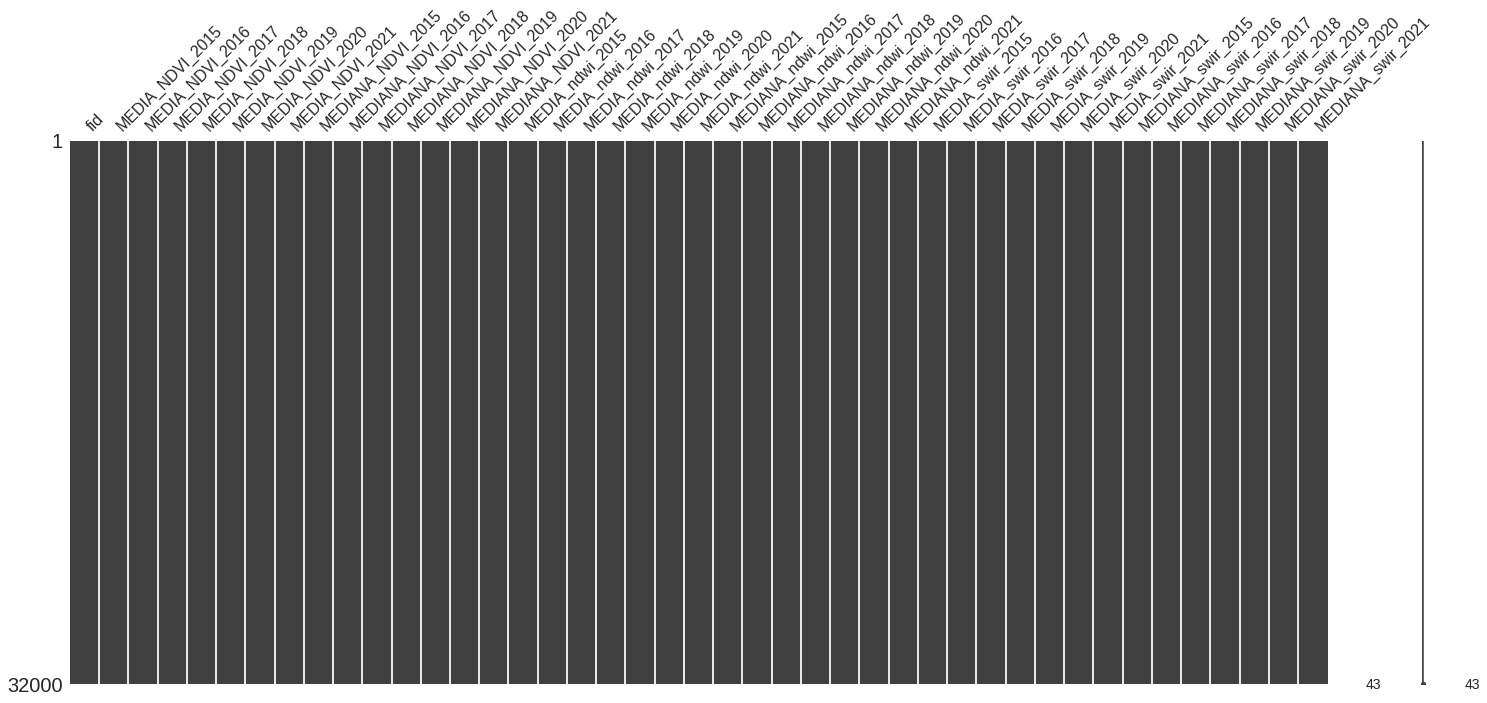

In [ ]:
# Criar gráficos estatísticos
msno.matrix(treinamento)
plt.show()

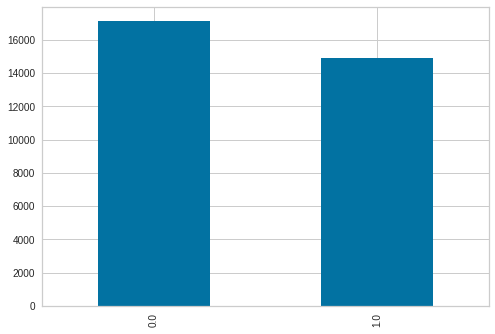

In [ ]:
# Criar gráficos estatísticos
y.value_counts().plot(kind="bar")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = treinamento.drop(columns="fid")
y=y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)
print(rf.score(X_test,y_test))
y_pred = rf.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_pred,y_test))

0.9246875
0.9190822607722439


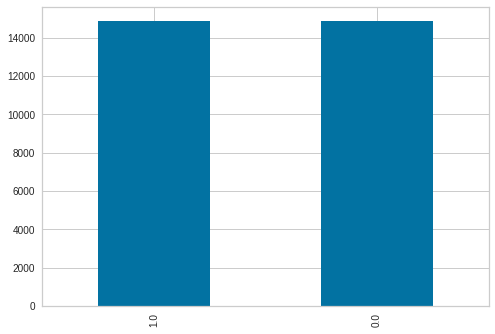

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 

under = RandomUnderSampler()
treinamento_resample = under.fit_resample(treinamento,y)

treinamento = treinamento_resample[0]
y=treinamento_resample[1]

treinamento_resample[1].value_counts().plot(kind="bar")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = treinamento_resample[0].drop(columns='fid')
y=treinamento_resample[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)
print(rf.score(X_test,y_test))
y_pred = rf.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_pred,y_test))




0.9221288515406163
0.9219539584503089


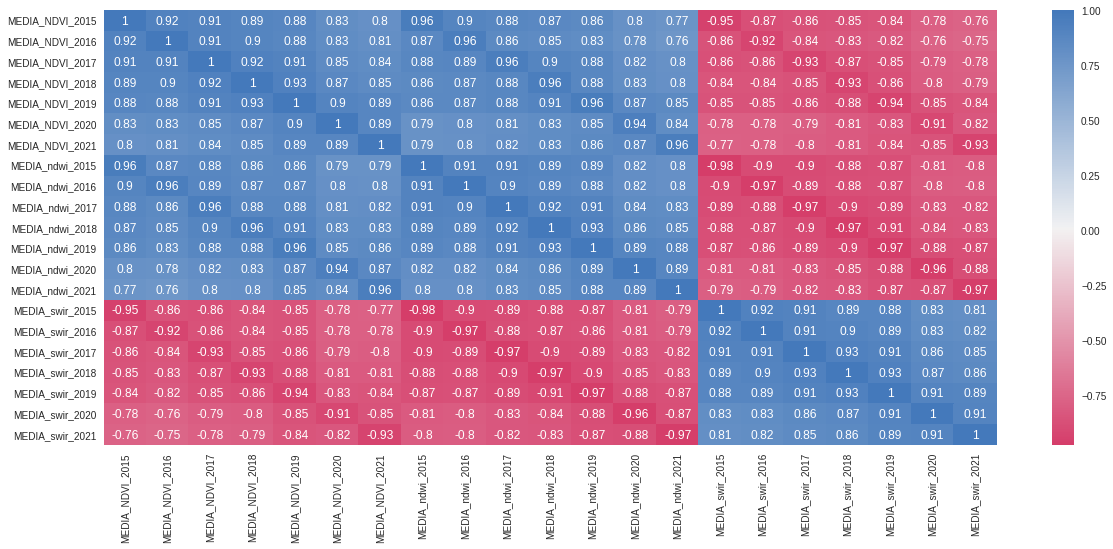

In [ ]:
treinamento.head()
treinamento2=treinamento.drop(columns='fid',inplace=False)
media_ndvi=treinamento2[['MEDIA_NDVI_2015','MEDIA_NDVI_2016','MEDIA_NDVI_2017','MEDIA_NDVI_2018','MEDIA_NDVI_2019','MEDIA_NDVI_2020','MEDIA_NDVI_2021']]
media_ndwi=treinamento2[['MEDIA_ndwi_2015','MEDIA_ndwi_2016','MEDIA_ndwi_2017','MEDIA_ndwi_2018','MEDIA_ndwi_2019','MEDIA_ndwi_2020','MEDIA_ndwi_2021']]
media_swir=treinamento2[['MEDIA_swir_2015','MEDIA_swir_2016','MEDIA_swir_2017','MEDIA_swir_2018','MEDIA_swir_2019','MEDIA_swir_2020','MEDIA_swir_2021']]

df_est=pd.concat([media_ndvi,media_ndwi,media_swir],axis=1)
corr=df_est.corr()
cmap = sns.diverging_palette(0, 250, as_cmap=True)
plt.figure(figsize=(20, 8))
hm=sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,cmap=cmap,annot=True,annot_kws={"size": 12})

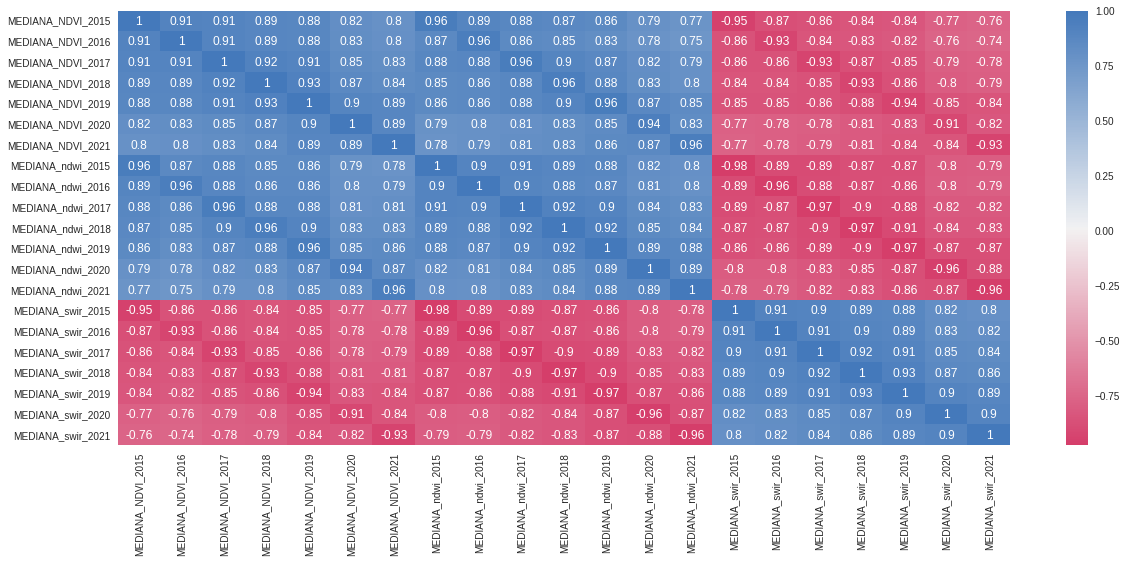

In [ ]:
MEDIANA_ndvi=treinamento2[['MEDIANA_NDVI_2015','MEDIANA_NDVI_2016','MEDIANA_NDVI_2017','MEDIANA_NDVI_2018','MEDIANA_NDVI_2019','MEDIANA_NDVI_2020','MEDIANA_NDVI_2021']]
MEDIANA_ndwi=treinamento2[['MEDIANA_ndwi_2015','MEDIANA_ndwi_2016','MEDIANA_ndwi_2017','MEDIANA_ndwi_2018','MEDIANA_ndwi_2019','MEDIANA_ndwi_2020','MEDIANA_ndwi_2021']]
MEDIANA_swir=treinamento2[['MEDIANA_swir_2015','MEDIANA_swir_2016','MEDIANA_swir_2017','MEDIANA_swir_2018','MEDIANA_swir_2019','MEDIANA_swir_2020','MEDIANA_swir_2021']]


df_est2=pd.concat([MEDIANA_ndvi,MEDIANA_ndwi,MEDIANA_swir],axis=1)

corr=df_est2.corr()
cmap = sns.diverging_palette(0, 250, as_cmap=True)
plt.figure(figsize=(20, 8))
hm=sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,cmap=cmap,annot=True,annot_kws={"size": 12})

In [ ]:
treinamento.head()

,fid,MEDIA_NDVI_2015,MEDIA_NDVI_2016,MEDIA_NDVI_2017,MEDIA_NDVI_2018,MEDIA_NDVI_2019,MEDIA_NDVI_2020,MEDIA_NDVI_2021,MEDIANA_NDVI_2015,MEDIANA_NDVI_2016,MEDIANA_NDVI_2017,MEDIANA_NDVI_2018,MEDIANA_NDVI_2019,MEDIANA_NDVI_2020,MEDIANA_NDVI_2021,MEDIA_ndwi_2015,MEDIA_ndwi_2016,MEDIA_ndwi_2017,MEDIA_ndwi_2018,MEDIA_ndwi_2019,MEDIA_ndwi_2020,MEDIA_ndwi_2021,MEDIANA_ndwi_2015,MEDIANA_ndwi_2016,MEDIANA_ndwi_2017,MEDIANA_ndwi_2018,MEDIANA_ndwi_2019,MEDIANA_ndwi_2020,MEDIANA_ndwi_2021,MEDIA_swir_2015,MEDIA_swir_2016,MEDIA_swir_2017,MEDIA_swir_2018,MEDIA_swir_2019,MEDIA_swir_2020,MEDIA_swir_2021,MEDIANA_swir_2015,MEDIANA_swir_2016,MEDIANA_swir_2017,MEDIANA_swir_2018,MEDIANA_swir_2019,MEDIANA_swir_2020,MEDIANA_swir_2021
0,1983,0.859391,0.870646,0.882350,0.883148,0.876673,0.869271,0.876391,0.859963,0.871635,0.880875,0.880645,0.876132,0.860094,0.875760,0.376797,0.397671,0.421074,0.425340,0.419730,0.404150,0.415223,0.372408,0.399251,0.422507,0.433705,0.417466,0.421887,0.416796,0.052533,0.049035,0.049433,0.050146,0.049832,0.050852,0.049972,0.051941,0.048050,0.049178,0.049893,0.050003,0.049123,0.048985
1,57001,0.839465,0.871345,0.870416,0.865124,0.862828,0.867560,0.863486,0.839218,0.870702,0.871722,0.871020,0.864644,0.867948,0.867553,0.400516,0.397528,0.410565,0.380889,0.396239,0.395354,0.382763,0.402249,0.397612,0.411434,0.392837,0.393705,0.394555,0.389322,0.046347,0.039656,0.039383,0.043107,0.042753,0.043816,0.047123,0.045699,0.039044,0.039161,0.042330,0.042653,0.043726,0.045300
2,27012,0.848353,0.872821,0.888138,0.891205,0.878020,0.865056,0.868913,0.848353,0.872821,0.888138,0.891205,0.878020,0.865056,0.868913,0.385053,0.413757,0.430877,0.440797,0.426277,0.407069,0.408679,0.385053,0.413757,0.430877,0.440797,0.426277,0.407069,0.408679,0.053495,0.052051,0.050085,0.048572,0.050717,0.053413,0.047115,0.053495,0.052051,0.050085,0.048572,0.050717,0.053413,0.047115
3,8366,0.849840,0.876481,0.880578,0.891528,0.882271,0.885029,0.881926,0.853294,0.880798,0.882274,0.890794,0.884033,0.886240,0.882669,0.388238,0.412992,0.424640,0.435009,0.433065,0.425750,0.431930,0.394113,0.416969,0.425206,0.436759,0.428656,0.425042,0.435286,0.055784,0.051446,0.052888,0.050034,0.050699,0.050918,0.050866,0.055269,0.050305,0.052189,0.049879,0.050415,0.050786,0.050346
4,52349,0.846828,0.870053,0.863472,0.869668,0.865106,0.862596,0.859139,0.849024,0.874903,0.880466,0.880649,0.873502,0.869959,0.873475,0.411077,0.406528,0.401125,0.400935,0.413710,0.400933,0.408063,0.413814,0.414386,0.424387,0.415551,0.422404,0.408527,0.425968,0.053012,0.049657,0.055400,0.054248,0.054672,0.055720,0.056500,0.052484,0.047892,0.049927,0.049226,0.050573,0.052374,0.051817


## 2- Preparação dos dados

In [ ]:
# atribuir os valores das variáveis independentes a 'X'
X=treinamento.drop(columns='fid')
y=y

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Dividir o dataset entre treino e teste  #random_state=None
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
print(X.shape)
print(y.shape)

(29748, 42)
(29748,)


In [ ]:
colnames=X.columns
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = colnames,
                                   columns=['importance'])#.sort_values('importance', ascending=False)
#feature_importances

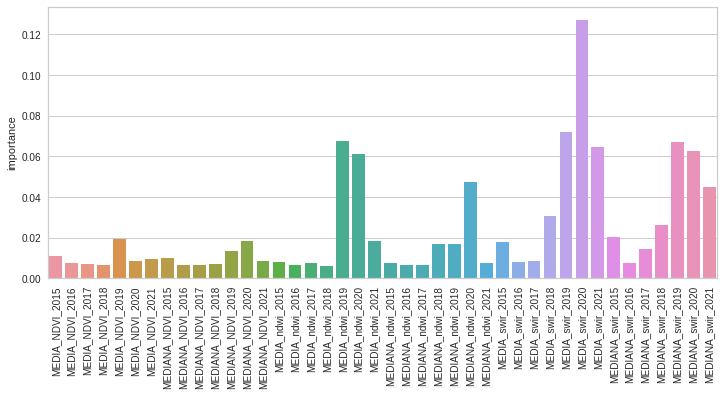

In [ ]:
plt.figure(figsize=(12,5))
g = sns.barplot(x=colnames,y=feature_importances['importance'])
g.tick_params(axis='x', rotation=90)
plt.show()

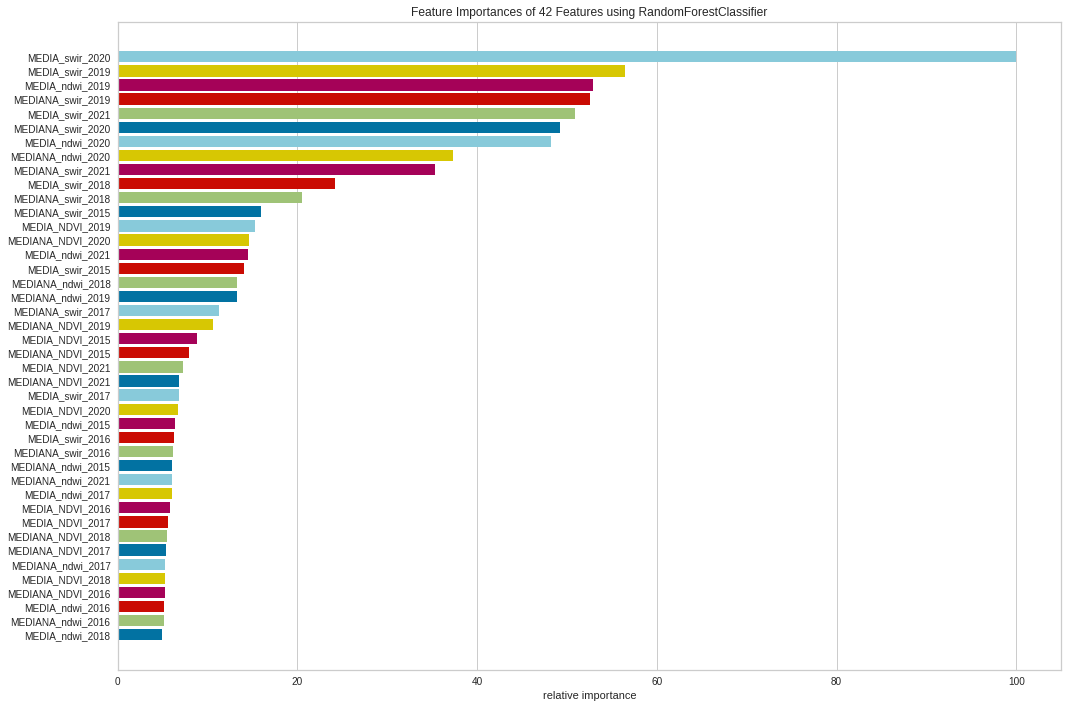

In [ ]:
from yellowbrick.features import FeatureImportances
plt.figure(figsize=(15,10))
model = RandomForestClassifier()
viz = FeatureImportances(rf)
viz.fit(X, y)
viz.show()

In [ ]:
import eli5
eli5.show_weights(rf, feature_names = X_train.columns.tolist())

Weight,Feature
0.1273 ± 0.4647,MEDIA_swir_2020
0.0719 ± 0.3503,MEDIA_swir_2019
0.0674 ± 0.3478,MEDIA_ndwi_2019
0.0669 ± 0.3280,MEDIANA_swir_2019
0.0647 ± 0.3341,MEDIA_swir_2021
0.0626 ± 0.3150,MEDIANA_swir_2020
0.0614 ± 0.3328,MEDIA_ndwi_2020
0.0475 ± 0.2746,MEDIANA_ndwi_2020
0.0450 ± 0.2768,MEDIANA_swir_2021
0.0308 ± 0.2253,MEDIA_swir_2018


In [ ]:
from eli5 import show_prediction
show_prediction(rf, X_train.iloc[1], feature_names = X_train.columns.tolist(), 
                show_feature_values=True)

In [ ]:
df2=df.iloc[:,2:]
treinamento=df2[pd.isna(df2['classe_amostra'])==False]
y=treinamento['classe_amostra']
treinamento=treinamento.drop(columns=['classe_amostra'])
treinamento=treinamento.fillna(treinamento.mean())
treinamento.shape

(32000, 43)

In [ ]:
X = treinamento.drop(columns='fid')
y=y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)
print(rf.score(X_test,y_test))
y_pred = rf.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_pred,y_test))

0.9246875
0.9190822607722439


In [ ]:
X_sem_swir = treinamento.drop(columns='fid')[['MEDIA_NDVI_2015', 'MEDIA_NDVI_2016', 'MEDIA_NDVI_2017',
       'MEDIA_NDVI_2018', 'MEDIA_NDVI_2019', 'MEDIA_NDVI_2020',
       'MEDIA_NDVI_2021', 'MEDIANA_NDVI_2015', 'MEDIANA_NDVI_2016',
       'MEDIANA_NDVI_2017', 'MEDIANA_NDVI_2018', 'MEDIANA_NDVI_2019',
       'MEDIANA_NDVI_2020', 'MEDIANA_NDVI_2021', 'MEDIA_ndwi_2015',
       'MEDIA_ndwi_2016', 'MEDIA_ndwi_2017', 'MEDIA_ndwi_2018',
       'MEDIA_ndwi_2019', 'MEDIA_ndwi_2020', 'MEDIA_ndwi_2021',
       'MEDIANA_ndwi_2015', 'MEDIANA_ndwi_2016', 'MEDIANA_ndwi_2017',
       'MEDIANA_ndwi_2018', 'MEDIANA_ndwi_2019', 'MEDIANA_ndwi_2020',
       'MEDIANA_ndwi_2021']]
y=y

X_train, X_test, y_train, y_test = train_test_split(X_sem_swir, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)
print(rf.score(X_test,y_test))
y_pred = rf.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_pred,y_test))

0.91625
0.9093982420554428


In [ ]:
X_so_swir = treinamento.drop(columns='fid')[['MEDIA_swir_2015', 'MEDIA_swir_2016',
       'MEDIA_swir_2017', 'MEDIA_swir_2018', 'MEDIA_swir_2019',
       'MEDIA_swir_2020', 'MEDIA_swir_2021', 'MEDIANA_swir_2015',
       'MEDIANA_swir_2016', 'MEDIANA_swir_2017', 'MEDIANA_swir_2018',
       'MEDIANA_swir_2019', 'MEDIANA_swir_2020', 'MEDIANA_swir_2021']]
y=y

X_train, X_test, y_train, y_test = train_test_split(X_so_swir, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)
print(rf.score(X_test,y_test))
y_pred = rf.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_pred,y_test))

0.9211458333333333
0.9148385645179435


In [ ]:
X_mais_importantes = treinamento.drop(columns='fid')[['MEDIA_swir_2020',
'MEDIA_ndwi_2019',
'MEDIANA_swir_2019',	
'MEDIA_swir_2019',
'MEDIA_ndwi_2020',	
'MEDIANA_swir_2021',	
'MEDIA_swir_2021',	
'MEDIANA_ndwi_2020',	
'MEDIANA_swir_2020',	
'MEDIA_swir_2018',	
'MEDIANA_swir_2018',	
'MEDIA_NDVI_2019',	
'MEDIANA_ndwi_2019',
'MEDIA_ndwi_2021',	
'MEDIANA_ndwi_2018',	
'MEDIANA_NDVI_2020',	
'MEDIANA_NDVI_2019',	
'MEDIANA_NDVI_2021',	
'MEDIA_NDVI_2017',	
'MEDIANA_swir_2017',	
'MEDIA_NDVI_2021',	
'MEDIA_swir_2017',
'MEDIANA_swir_2015',
'MEDIA_ndwi_2015',
'MEDIA_NDVI_2015',	
'MEDIA_NDVI_2016',
'MEDIA_ndwi_2017',
'MEDIANA_NDVI_2016',
'MEDIANA_ndwi_2015',
'MEDIA_ndwi_2018',	
'MEDIANA_ndwi_2017',
'MEDIANA_ndwi_2021',
'MEDIANA_NDVI_2018',
'MEDIANA_NDVI_2015',
'MEDIA_swir_2015', 
'MEDIANA_swir_2016']]

y=y

X_train, X_test, y_train, y_test = train_test_split(X_mais_importantes, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)
print(rf.score(X_test,y_test))
y_pred = rf.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_pred,y_test))

0.9245833333333333
0.9188158779995514


3) **TESTES DE TREINAMENTO COM DIFERENTES ALGORITMOS** 

In [ ]:
#LENDO OS DADOS QUE SERÃO USADOS NO RESTANTE DO TRABALHO
X_mais_importantes = treinamento.drop(columns='fid')[['MEDIA_swir_2020',
'MEDIA_ndwi_2019',
'MEDIANA_swir_2019',	
'MEDIA_swir_2019',
'MEDIA_ndwi_2020',	
'MEDIANA_swir_2021',	
'MEDIA_swir_2021',	
'MEDIANA_ndwi_2020',	
'MEDIANA_swir_2020',	
'MEDIA_swir_2018',	
'MEDIANA_swir_2018',	
'MEDIA_NDVI_2019',	
'MEDIANA_ndwi_2019',
'MEDIA_ndwi_2021',	
'MEDIANA_ndwi_2018',	
'MEDIANA_NDVI_2020',	
'MEDIANA_NDVI_2019',	
'MEDIANA_NDVI_2021',	
'MEDIA_NDVI_2017',	
'MEDIANA_swir_2017',	
'MEDIA_NDVI_2021',	
'MEDIA_swir_2017',
'MEDIANA_swir_2015',
'MEDIA_ndwi_2015',
'MEDIA_NDVI_2015',	
'MEDIA_NDVI_2016',
'MEDIA_ndwi_2017',
'MEDIANA_NDVI_2016',
'MEDIANA_ndwi_2015',
'MEDIA_ndwi_2018',	
'MEDIANA_ndwi_2017',
'MEDIANA_ndwi_2021',
'MEDIANA_NDVI_2018',
'MEDIANA_NDVI_2015',
'MEDIA_swir_2015', 
'MEDIANA_swir_2016']]

y=y


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
NUMERO_FEATURES = X_train.shape[1]

In [ ]:
! pip install scikit-optimize

     |████████████████████████████████| 100 kB 4.1 MB/s 


**3.1) RANDOM FOREST**

In [ ]:
X = treinamento.drop(columns="fid")
y=y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
        "max_depth": Integer(5, 30),
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 100),
        "max_samples": Real(0.4, 1.0),
        "n_estimators": Integer(100, 1000)
    }

forest_clf = RandomForestClassifier()

In [ ]:

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, # specify how many iterations
                                    scoring="roc_auc", n_jobs=-1, cv=5, verbose=100)

forest_bayes_search.fit(X_train, y_train) # callback=on_step will print score after each iteration



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
              scoring='roc_auc',
              search_spaces={'max_depth': Integer(low=5, high=30, prior='uniform', transform='normalize'),
                             'max_samples': Real(low=0.4, high=1.0, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize')},
              verbose=100)

In [ ]:
forest_bayes_search.best_estimator_

RandomForestClassifier(max_depth=26, max_samples=1.0, min_samples_leaf=3,
                       n_estimators=595)

In [ ]:
forest_bayes_search.best_score_

0.9696055675649108

In [ ]:
forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, # specify how many iterations
                                    scoring="roc_auc", n_jobs=-1, cv=5, verbose=100)

forest_bayes_search.fit(X, y) # callback=on_step will print score after each iteration

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
forest_bayes_search.best_estimator_

In [ ]:
forest_bayes_search.best_score_

**Classificação final**

In [ ]:
rf = RandomForestClassifier(max_depth=26, max_samples=1.0, min_samples_leaf=3, n_estimators=595)
rf.fit(X,y)

RandomForestClassifier(max_depth=26, max_samples=1.0, min_samples_leaf=3,
                       n_estimators=595)

In [ ]:
dados_previsao.head()

,classe_amostra,fid,MEDIA_NDVI_2015,MEDIA_NDVI_2016,MEDIA_NDVI_2017,MEDIA_NDVI_2018,MEDIA_NDVI_2019,MEDIA_NDVI_2020,MEDIA_NDVI_2021,MEDIANA_NDVI_2015,MEDIANA_NDVI_2016,MEDIANA_NDVI_2017,MEDIANA_NDVI_2018,MEDIANA_NDVI_2019,MEDIANA_NDVI_2020,MEDIANA_NDVI_2021,MEDIA_ndwi_2015,MEDIA_ndwi_2016,MEDIA_ndwi_2017,MEDIA_ndwi_2018,MEDIA_ndwi_2019,MEDIA_ndwi_2020,MEDIA_ndwi_2021,MEDIANA_ndwi_2015,MEDIANA_ndwi_2016,MEDIANA_ndwi_2017,MEDIANA_ndwi_2018,MEDIANA_ndwi_2019,MEDIANA_ndwi_2020,MEDIANA_ndwi_2021,MEDIA_swir_2015,MEDIA_swir_2016,MEDIA_swir_2017,MEDIA_swir_2018,MEDIA_swir_2019,MEDIA_swir_2020,MEDIA_swir_2021,MEDIANA_swir_2015,MEDIANA_swir_2016,MEDIANA_swir_2017,MEDIANA_swir_2018,MEDIANA_swir_2019,MEDIANA_swir_2020,MEDIANA_swir_2021
1,NaN,2,0.826198,0.861789,0.858303,0.876121,0.843605,0.857290,0.857423,0.831246,0.865362,0.854957,0.871255,0.838356,0.863312,0.863969,0.391470,0.404147,0.387315,0.421452,0.408952,0.436466,0.418396,0.382412,0.402343,0.372811,0.408203,0.421082,0.433053,0.406094,0.041624,0.038145,0.036294,0.034337,0.038773,0.035162,0.037316,0.040515,0.036830,0.036060,0.034039,0.036390,0.037834,0.039621
3,NaN,4,0.840929,0.840058,0.832866,0.846502,0.839763,0.830259,0.850966,0.840929,0.840058,0.832866,0.846502,0.839763,0.830259,0.850966,0.398562,0.384476,0.384224,0.406581,0.438750,0.454734,0.452517,0.398562,0.384476,0.384224,0.406581,0.438750,0.454734,0.452517,0.039717,0.035634,0.034644,0.033571,0.038178,0.032196,0.032609,0.039717,0.035634,0.034644,0.033571,0.038178,0.032196,0.032609
7,NaN,8,0.839389,0.858656,0.863211,0.874242,0.859572,0.853679,0.869223,0.839389,0.858656,0.863211,0.874242,0.859572,0.853679,0.869223,0.378657,0.383391,0.375956,0.389287,0.372518,0.398339,0.396942,0.378657,0.383391,0.375956,0.389287,0.372518,0.398339,0.396942,0.049755,0.046799,0.048669,0.046991,0.047472,0.046290,0.045603,0.049755,0.046799,0.048669,0.046991,0.047472,0.046290,0.045603
8,NaN,9,0.844355,0.857786,0.866872,0.871467,0.864374,0.863333,0.873615,0.842285,0.858189,0.865106,0.871935,0.862364,0.863767,0.875707,0.377856,0.389295,0.402227,0.404883,0.400821,0.415620,0.415493,0.374165,0.387247,0.399540,0.406392,0.396153,0.417802,0.412281,0.049113,0.044180,0.043799,0.043430,0.044110,0.044776,0.043416,0.049095,0.044448,0.044131,0.043746,0.043980,0.045864,0.044159
9,NaN,10,0.866410,0.863013,0.878419,0.884443,0.882508,0.891164,0.895696,0.866410,0.863013,0.878419,0.884443,0.882508,0.891164,0.895696,0.396192,0.422735,0.438081,0.466510,0.446831,0.469991,0.476678,0.396192,0.422735,0.438081,0.466510,0.446831,0.469991,0.476678,0.044379,0.041141,0.040137,0.037036,0.039278,0.037916,0.040673,0.044379,0.041141,0.040137,0.037036,0.039278,0.037916,0.040673


In [ ]:
X_previsao=dados_previsao.drop(columns=['fid','classe_amostra'])
y_previsao=rf.predict(X_previsao)

In [ ]:
df_treinamento = pd.concat([treinamento['fid'], pd.Series(y)], axis=1)
df_previsao = pd.concat([dados_previsao['fid'].reset_index()['fid'], pd.Series(y_previsao) ], axis=1)
df_previsao = df_previsao.rename(columns={0: 'classe_amostra'})
df_final = pd.concat([df_treinamento,df_previsao])
df_final=df_final.sort_values(by=['fid'])
df_final.head()

,fid,classe_amostra
0,1,0.0
0,2,0.0
2,3,0.0
1,4,0.0
4,5,0.0


In [ ]:
from google.colab import files

df_final.to_csv('df_final.csv',index=False)
files.download('df_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**3.2) Escolha de um modelo**

In [ ]:
X = treinamento.drop(columns="fid")
y=y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(22400, 42)

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
metrics = ['roc_auc','balanced_accuracy', 'average_precision', 'recall', 'accuracy', 'f1_macro','f1_weighted']

results = [
    
]

model = [
    RandomForestClassifier,
    LogisticRegression,
    XGBClassifier,
    KNeighborsClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    SGDClassifier,
    SVC, 
    NuSVC, 
    LinearSVC,
    BernoulliNB, 
    LGBMClassifier,
    MLPClassifier,
    AdaBoostClassifier,
]


params = [
    {
        'n_estimators': [100],
        'max_depth': [5,7,9],
        'min_samples_split': [2,3],
        'min_samples_leaf': [1,2],
        'random_state': [DEFAULT_RANDOM_STATE],
        'max_samples': [.8, 1],
    },
    {
        'penalty' : ['l2'],
        'C' : [1],
        'solver' : ['liblinear'],
        'random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'learning_rate': [0.01],
        'n_estimators': [100],
        'subsample' : [.8,.45],
        'min_child_weight': [1],
        'max_depth': [3,4,7],
        'random_state': [DEFAULT_RANDOM_STATE],
        'reg_lambda': [2],
    },
    {
        'n_neighbors' : [5,7,9,11],
    },
    {
        'n_estimators': [100],
        'max_samples': [.8],
        'random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'n_estimators': [100],
        'max_samples' : [.8],
        'max_depth': [6,7],
        'random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'gamma': ['auto'],
        'C': [0.5],
    },
    {
        'gamma': ['auto'],
        'random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'random_state': [DEFAULT_RANDOM_STATE],
    },
    {
    },
    {
        'n_estimators': [100],
        'subsample': [.6,.7,.8,1],
        'random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'alpha': [1], 
        'max_iter': [100],
    },
    {
    }
]

import pdb

logging.info('Início')

# itera a lista de modelos e seus hiperparâmetros
lista_mh = list(zip(model, params))

df_results = pd.DataFrame(results)

for m, p in tqdm.tqdm_notebook(lista_mh):
    logging.info('Modelo: {}'.format(m.__name__))
    
    rskfcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=DEFAULT_RANDOM_STATE)
    
    # utiliza o HalvingGridSearchCV para encontrar o melhor conjunto de hiperparâmetros 
    # que maximizem o roc_auc score
    cv = HalvingGridSearchCV(estimator=m(),param_grid=p, n_jobs=N_JOBS, error_score=0, refit=True, scoring='roc_auc', cv=rskfcv, verbose=100)
    cv.fit(X_train, y_train)
    model = cv.best_estimator_
    best_params = cv.best_params_
    
    # instancia o modelo com os hiperparâmetros escolhidos acima e utiliza validação cruzada 
    # para avaliar todas as métricas escolhidas
    valores = cross_validate(m(**best_params), X_train, y_train, scoring=metrics, cv=rskfcv)
    cv_scores = {k[5:]: np.mean(v) for k, v in valores.items() if k not in ['fit_time', 'score_time']}
    
    # monta um registro com todas as informações coletadas para comparação
    linha = {
        'Modelo': m.__name__,
        'ScoreTreino': cv.score(X_train, y_train),
        'BestParams': best_params,
        'RawScores': {k[5:]: v for k, v in valores.items() if k not in ['fit_time', 'score_time']}
    }
    linha.update(cv_scores)
    results.append(linha)

    #df_results.sort_values('roc_auc', ascending=False)
    df_results.to_csv("analisedemodelos.csv")
    #df_results.outfile.close() 

  0%|          | 0/14 [00:00<?, ?it/s]

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2488
max_resources_: 22400
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 2488
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 1
n_candidates: 8
n_resources: 7464
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 3
n_resources: 22392
Fitting 10 folds for each of 3 candidates, totalling 30 fits
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 22400
max_resources_: 22400
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 22400
Fitting 10 folds for each of 1 candidates, totalling 10 fits
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 7466
max_resources_: 22400
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 7466
Fitting 10 folds for each of 6 candida

In [ ]:
# tabela comparativa com os resultados apresentados por cada algoritmo executado
df_results = pd.DataFrame(results)
df_results.sort_values('roc_auc', ascending=False)

,Modelo,ScoreTreino,BestParams,RawScores,roc_auc,balanced_accuracy,average_precision,recall,accuracy,f1_macro,f1_weighted
11,LGBMClassifier,0.990823,"{'n_estimators': 100, 'random_state': 42, 'sub...","{'roc_auc': [0.965585904678603, 0.975923349441...",0.969193,0.917453,0.964671,0.914234,0.917679,0.917305,0.917688
4,BaggingClassifier,0.999990,"{'max_samples': 0.8, 'n_estimators': 100, 'ran...","{'roc_auc': [0.9633391564561772, 0.97236739980...",0.967190,0.917009,0.959625,0.913180,0.917277,0.916896,0.917284
0,RandomForestClassifier,0.980768,"{'max_depth': 9, 'max_samples': 0.8, 'min_samp...","{'roc_auc': [0.9630868478322685, 0.97316157123...",0.967020,0.916652,0.963283,0.910877,0.917054,0.916648,0.917049
2,XGBClassifier,0.974149,"{'learning_rate': 0.01, 'max_depth': 7, 'min_c...","{'roc_auc': [0.9622073720575007, 0.97276548674...",0.966044,0.916706,0.961674,0.911069,0.917098,0.916694,0.917095
5,ExtraTreesClassifier,0.963467,"{'max_depth': 7, 'max_samples': 0.8, 'n_estima...","{'roc_auc': [0.955336968179477, 0.969227959640...",0.960717,0.907956,0.958225,0.883631,0.909643,0.908939,0.909492
13,AdaBoostClassifier,0.962527,{},"{'roc_auc': [0.9532307919046579, 0.96167311855...",0.958158,0.901459,0.952782,0.885167,0.902589,0.901968,0.902505
3,KNeighborsClassifier,0.978672,{'n_neighbors': 11},"{'roc_auc': [0.9490721049988347, 0.96584141722...",0.957937,0.911268,0.939516,0.898021,0.912187,0.911664,0.912133
9,LinearSVC,0.956384,{'random_state': 42},"{'roc_auc': [0.950143815915628, 0.961947854615...",0.955991,0.884484,0.953811,0.821659,0.888839,0.887070,0.888047
6,SGDClassifier,0.953593,{'random_state': 42},"{'roc_auc': [0.9466747725818221, 0.96105075728...",0.953362,0.890285,0.952633,0.837101,0.893973,0.892495,0.893360
1,LogisticRegression,0.953239,"{'C': 1, 'penalty': 'l2', 'random_state': 42, ...","{'roc_auc': [0.9459034290744439, 0.96065347132...",0.952675,0.882634,0.952014,0.818876,0.887054,0.885235,0.886233


In [ ]:
#df_results = pd.read_csv("analisedemodelos.csv")

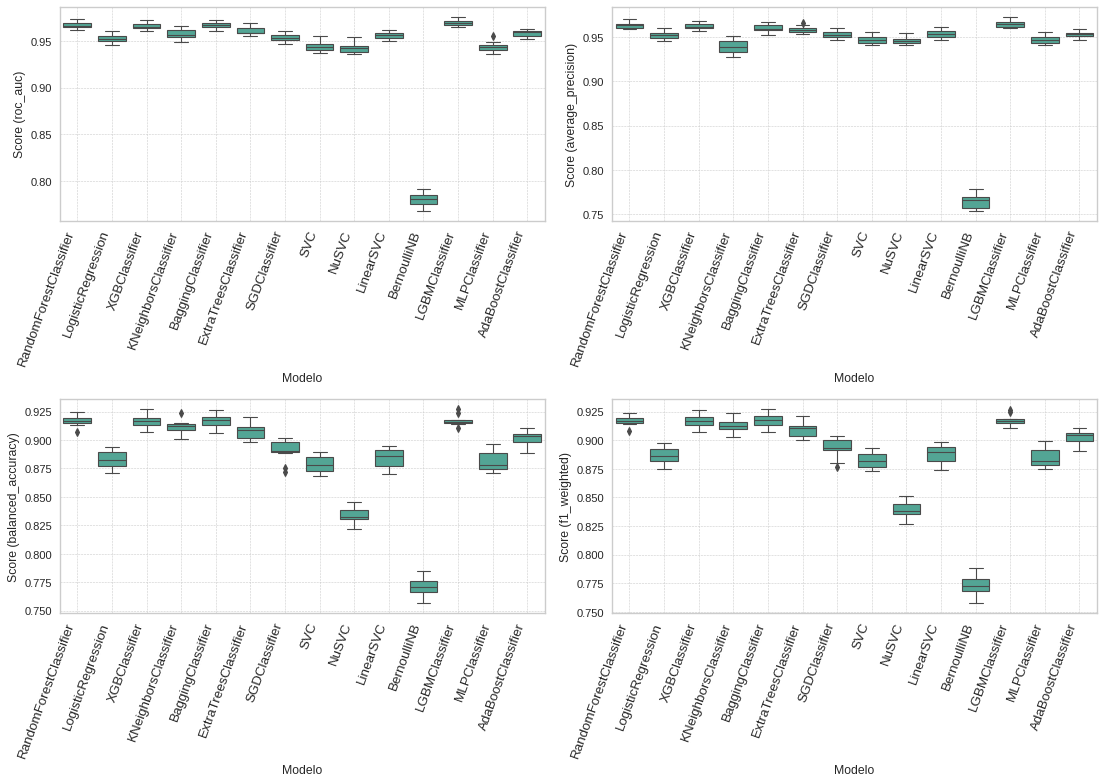

In [ ]:
metricas = ['roc_auc', 'average_precision', 'balanced_accuracy', 'f1_weighted' ]

matplotlib.rcParams.update({'font.size': 13})
fig, axis = plt.subplots(2,2, figsize=(14, 10), dpi=80)

axis = np.ravel(axis)
for i, m in enumerate(metricas):
    df_score = pd.DataFrame({m: s for m, s in zip(df_results['Modelo'], df_results['RawScores'].apply(lambda x: x[m]))})
    df_score = pd.melt(df_score, var_name='Modelo', value_name='Score')
    sns.boxplot(x='Modelo', y='Score', data=df_score, color='#45B39D', linewidth=1, ax=axis[i])
    axis[i].set_xlabel('Modelo')
    axis[i].set_ylabel(f'Score ({m})')
    axis[i].set_xticklabels(labels=df_score['Modelo'].drop_duplicates(), rotation=70, ha='right', fontsize=12)
    axis[i].grid(which='major',linestyle='--', linewidth=0.5, )
    
plt.tight_layout()
plt.show()

In [ ]:
df_results.BestParams[0]

{'max_depth': 9,
 'max_samples': 0.8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 42}